In [1]:
import tensorflow as tf
import numpy as np 
from tensorflow import keras


2025-05-04 07:40:48.532216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746333648.545710   23861 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746333648.549585   23861 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 07:40:48.564013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

In [4]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
encoded_train_label = keras.utils.to_categorical(train_labels, num_classes=10)
encoded_test_label = keras.utils.to_categorical(test_labels, num_classes=10)
print(encoded_train_label.shape)
print(encoded_test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
(60000, 784)
(60000,)
(10000, 784)
(10000,)
(60000, 10)
(10000, 10)


# MLP realted stuff

In [5]:
def model_create(input_dim , output_dim , hidden): # hidden here is a array each number represnet the numpber of nurons in each hidden layer
    model = keras.Sequential()
    model.add(keras.layers.Dense(hidden[0], input_shape=(input_dim,),activation='relu')) # input layers with dim 28*28 for our problem

    for nueron in hidden[1:]:
        model.add(keras.layers.Dense(nueron, activation='relu'))

    model.add(keras.layers.Dense(output_dim, activation='softmax'))

    return model
    
    
    

In [6]:
def extract_weight(model):
    weights = []

    for layer in model.layers:
        layer_weights = layer.get_weights()

        weights.extend([w.flatten() for w in layer_weights])
    return np.concatenate(weights)
    

In [7]:
def return_weights_toModel(model,weight_vector):
    #save shapes
    idx=0

    for i, layer in enumerate(model.layers):  # enumerate to make no iterable items iterable reutrn index i here for example
        layer_weight = layer.get_weights()

        new_weights= [] # new list of weights

        for j,w in enumerate(layer_weight): # j index from enumerate i didnt used it because i dont need it 
            
            n_weights = w.size

            new_w = weight_vector[idx:idx + n_weights].reshape(w.shape)

            new_weights.append(new_w)

            idx += n_weights

        layer.set_weights(new_weights)

    return model  # model with updated layers
    

# fitness function

In [8]:
def fitness_function(x_train, y_train, original_model, weight_vector):

    model_copy = keras.models.clone_model(original_model) # model with new wieght to test with 
    model_copy.build(original_model.input_shape) # without build : erorr weight is not defined in next line when i try to set weight

    return_weights_toModel(model_copy, weight_vector)

    model_copy.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'] 
    )
    
    loss,accuracy = model_copy.evaluate(x_train, y_train, verbose=0)  # verbose because when testing i got alot of green bars


    return accuracy    

/home/theodoros/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746333653.800070   23861 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2169 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


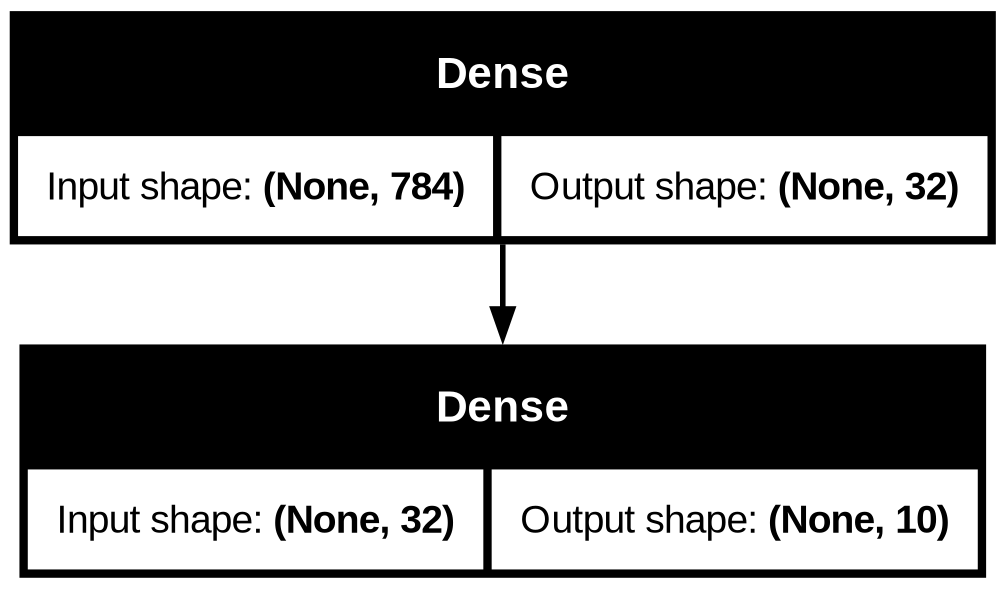

In [9]:
# test example 
model = model_create(input_dim=28*28 , output_dim=10 , hidden=[32])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

# weight_vecotor_test = extract_weight(model)
# print(weight_vecotor_test)

# mse = fitness_function(train_images,encoded_train_label, model, weight_vecotor_test)
# print("mse is : ",mse)

# intialzation function

DONT FORGET HERE WHERE YOU SET SEED!!!!


In [10]:
# tf.random.set_seed(24)
# np.random.seed(24)
def intialize_population(model, population_size, min_val=0 , max_val=1.0):

    weights = extract_weight(model) 
    # to get the length to create the new at the same size

    num_weights = len(weights)

    population = tf.random.uniform(
        shape = (population_size, num_weights),
        minval=min_val,
        maxval=max_val,
        dtype = tf.float32
        
    )

    population_np = population.numpy()


    return population_np
    

In [11]:
# test
NP=10
population=intialize_population(model,NP)

In [12]:
population.shape


(10, 25450)

In [13]:
population

array([[0.2723117 , 0.03141403, 0.3328166 , ..., 0.9410806 , 0.9876138 ,
        0.43675733],
       [0.7429439 , 0.8438544 , 0.33607006, ..., 0.71098435, 0.87800264,
        0.26874638],
       [0.3168056 , 0.24616826, 0.2110889 , ..., 0.66668177, 0.10064614,
        0.6788213 ],
       ...,
       [0.53021896, 0.6548767 , 0.4723221 , ..., 0.3494923 , 0.50498676,
        0.80831397],
       [0.23571432, 0.64557135, 0.08699679, ..., 0.62873983, 0.3639083 ,
        0.12107956],
       [0.5350357 , 0.7827263 , 0.55652785, ..., 0.5223907 , 0.9011388 ,
        0.43971908]], dtype=float32)

In [14]:
D = len(extract_weight(model))
print("number of genes is : ",D)

number of genes is :  25450


In [ ]:
# other parmeters

F = 0.5
CR = 0.7
GEN= 600

# constrains

L= -1
H= 1


In [16]:
# selection for the 3 random parent i prreffered to make it a function for editing later 
def random_vectors(population, current_index):
    
    population_size = population.shape[0]

    # remove the target vectory  

    population2 = list(range(population_size))
    population2.remove(current_index)

    # choosing indices 
    indexs = np.random.choice(population2, size=3 , replace=False)

    v1 = population[indexs[0]]
    v2 = population[indexs[1]]
    v3 = population[indexs[2]]

    return v1, v2, v3



# test 

x1,x2,x3 = random_vectors(population,5)
print(x2)
print(x2.shape)

# dont forget to check glitch with seed here later 
    

[0.5350357  0.7827263  0.55652785 ... 0.5223907  0.9011388  0.43971908]
(25450,)


# mutation and crossover function

In [17]:
def mutate(x1,x2,x3 , F, D,L=-1, H=1):
    v = np.zeros(D)
    
    for i in range(D):
        v[i] = x3[i]+ F* (x1[i] - x2[i])

        if v[i] < L or v[i] > H:
            v[i] = L + np.random.random() * (H - L) # (h-l ) to normalize the random number to fit between them

    return v

# the old version had  a problem handling constrains 

# def mutate (x1,x2,x3,F):
#     v = x3+F*(x1-x2)

#     return v


# test 
v = mutate(x1,x2,x3 ,.9 ,D)
print(v.shape)
print (v)

(25450,)
[ 0.07590458 -0.4514882   0.02192155 ... -0.84853825  0.26717043
  0.65194935]


In [18]:
def crossover(target_vector , mutant_vector ,CR,D):

    trial_vector = np.zeros(D)

    for i in range(D):
        r = np.random.random()
    
        if r < CR:
            trial_vector[i] = mutant_vector[i]

        else:
            trial_vector[i] = target_vector[i]

    return trial_vector
    
        

    
    

In [19]:
import gc
def evolve(population, GEN, NP, D, F, CR, model, x_train, y_train, L=0, H=1):
    best_solution = None
    best_overall_fitness = 0
    
    for g in range(GEN):
        new_population = np.zeros_like(population)
        fitness_scores = np.zeros(NP)
        
        for j in range(NP):
            v1, v2, v3 = random_vectors(population, j)
            mutant_child = mutate(v1, v2, v3, F, D, L, H)
            target_vector = population[j]
            trial_vector = crossover(target_vector, mutant_child, CR, D)

            trial_fitness = fitness_function(x_train, y_train, model, trial_vector)
            target_fitness = fitness_function(x_train, y_train, model, target_vector)

            if trial_fitness > target_fitness:  # Higher is better for accuracy
                new_population[j] = trial_vector
                fitness_scores[j] = trial_fitness
            else:
                new_population[j] = target_vector
                fitness_scores[j] = target_fitness
        
        # Find best in this generation
        best_fitness = np.max(fitness_scores)
        best_index = np.argmax(fitness_scores)
        
        # Track best overall solution
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_solution = new_population[best_index].copy()
        
        population = new_population.copy()
                
        print(f"Generation {g}: Best fitness (accuracy) = {best_fitness}")
        gc.collect()
    
    return best_solution

In [20]:
train_evolv = train_images[:1000]
labels_evolv =encoded_train_label[:1000]
best_solution = evolve(population, GEN, NP, D, F, CR, model, train_evolv, labels_evolv, L, H)


I0000 00:00:1746333655.143553   24071 service.cc:148] XLA service 0x7fe6b0006ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746333655.143573   24071 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-04 07:40:55.152290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746333655.170164   24071 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746333655.454966   24071 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Generation 0: Best fitness (accuracy) = 0.11900000274181366
Generation 1: Best fitness (accuracy) = 0.11900000274181366
Generation 2: Best fitness (accuracy) = 0.12800000607967377
Generation 3: Best fitness (accuracy) = 0.13600000739097595
Generation 4: Best fitness (accuracy) = 0.13600000739097595
Generation 5: Best fitness (accuracy) = 0.1509999930858612
Generation 6: Best fitness (accuracy) = 0.1509999930858612
Generation 7: Best fitness (accuracy) = 0.1509999930858612
Generation 8: Best fitness (accuracy) = 0.1509999930858612
Generation 9: Best fitness (accuracy) = 0.1509999930858612
Generation 10: Best fitness (accuracy) = 0.1589999943971634
Generation 11: Best fitness (accuracy) = 0.1589999943971634
Generation 12: Best fitness (accuracy) = 0.1589999943971634
Generation 13: Best fitness (accuracy) = 0.1589999943971634
Generation 14: Best fitness (accuracy) = 0.1589999943971634
Generation 15: Best fitness (accuracy) = 0.1589999943971634
Generation 16: Best fitness (accuracy) = 0.15

KeyboardInterrupt: 

In [ ]:
best_solution

In [ ]:
model_best = return_weights_toModel(model, best_solution)

In [ ]:
    model_best.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    accuracy = model_best.evaluate(train_images, encoded_train_label) 
